In [6]:
import pandas as pd
import os
data = ['dataSet_1','dataSet_2','dataSet_3','function_smoke_test']
requests = pd.read_json(os.path.join(data[3],'requests'),lines=True)
metas = pd.read_json(os.path.join(data[3],'metas'),lines=True)

In [7]:
requests['endTime'] = requests['startTime'] + requests['durationsInMs']
requests = requests.sort_values(by=['metaKey', 'startTime'])
def calculate_idle_time(group):
    group = group.sort_values(by='endTime')
    group['next_startTime'] = group['startTime'].shift(-1)
    group['idle_time'] = group['next_startTime'] - group['endTime']
    return group

requests = requests.groupby('metaKey').apply(calculate_idle_time)
requests['idle_time'] = requests['idle_time'].fillna(0)
requests.loc[requests['idle_time'] < 0, 'idle_time'] = 0
requests['idle_time_in_sec'] = requests['idle_time'] /1000

In [12]:
idle_time_stats = requests.groupby(level='metaKey')['idle_time_in_sec'].describe()
idle_time_stats_filtered = idle_time_stats[idle_time_stats['count'] > 10]
metas = metas.rename(columns={'key': 'metaKey'})
merged = metas.merge(idle_time_stats_filtered, on='metaKey', how='inner')
merged

,metaKey,runtime,memoryInMb,timeoutInSecs,initDurationInMs,count,mean,std,min,25%,50%,75%,max
0,59604e0de19592edd848d362fe515f9d88458617,custom,8192,60,3085,13.0,0.044154,0.047688,0.0,0.0090,0.022,0.07300,0.142
1,a4be92b8b8051a178b2c5520bf9cb9cc96c6ae3d,container,4096,60,15481,38.0,0.029105,0.044247,0.0,0.0060,0.012,0.03500,0.214
2,f102b8535b7743fe81e1df421ee930c1d35a9266,php,256,60,147,12.0,0.000667,0.002309,0.0,0.0000,0.000,0.00000,0.008
3,f019399e26b2618681f4668ece7038968f99ebeb,container,1024,7200,4950,101.0,0.005822,0.009618,0.0,0.0000,0.001,0.00900,0.058
4,36bf9a5965e2bc6eb21d749b35f69500071adef2,custom,256,120,1655,110.0,0.000200,0.002098,0.0,0.0000,0.000,0.00000,0.022
5,bfd79f355fddc01f12ef176dc5e08590574bb3c8,php,128,60,143,152.0,0.000000,0.000000,0.0,0.0000,0.000,0.00000,0.000
6,70730cd24bb415306f30eaedb3c3838d2ebebc0c,nodejs,128,60,287,11.0,0.080545,0.112766,0.0,0.0140,0.031,0.10750,0.365
7,7ab4926bf7de91ed1b8d85f52b32ad4e206d43e6,php,256,90,97,35.0,0.004029,0.016420,0.0,0.0000,0.000,0.00000,0.094
8,3e883b5a65dc5381bccd603adc123405c85115a1,java,512,60,5139,12.0,0.021417,0.042352,0.0,0.0000,0.000,0.01875,0.133
9,7afe8d0bd7e6dae9b6e980bdc5aa627a570eb02b,custom,3072,60,7402,34.0,0.017676,0.019484,0.0,0.0000,0.011,0.02925,0.059


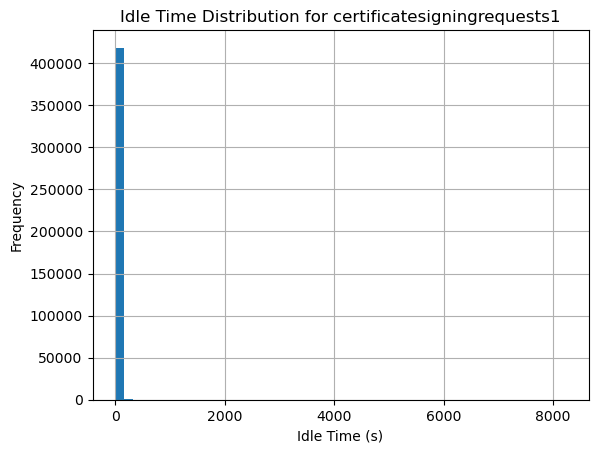

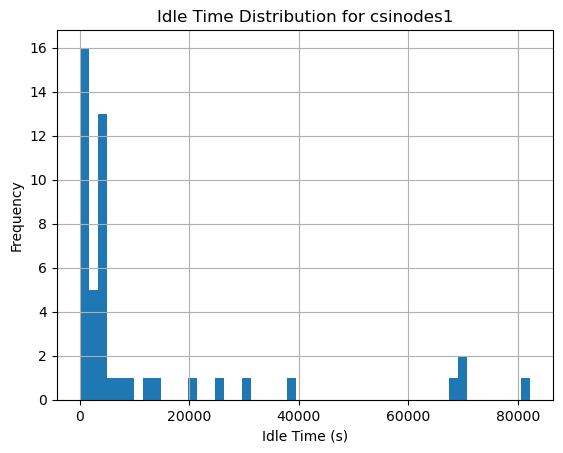

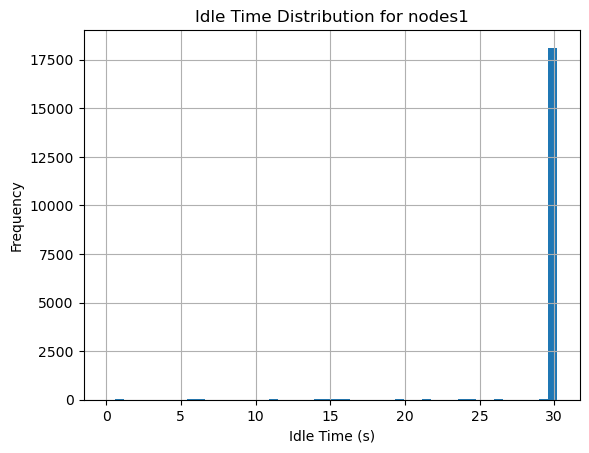

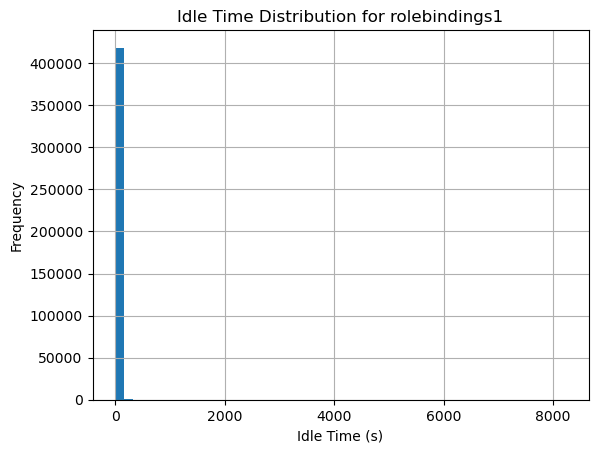

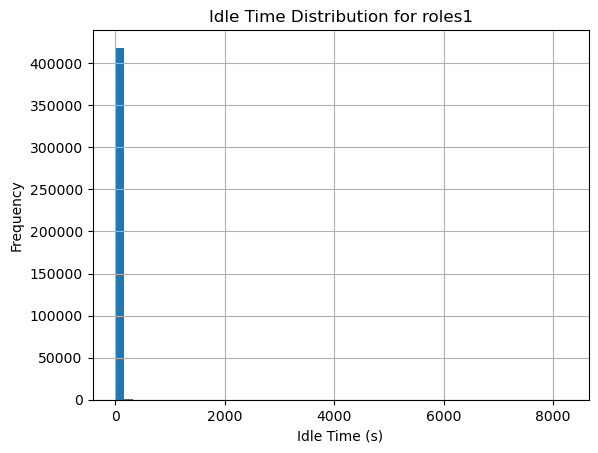

In [4]:
import matplotlib.pyplot as plt

# 获取所有唯一的metaKeys
meta_keys = requests['metaKey'].unique()

# 为每个metaKey创建一个直方图
for key in meta_keys:
    # 过滤掉请求次数小于10的metaKey
    if idle_time_stats.loc[key]['count'] < 10:
        continue
    requests[requests['metaKey'] == key]['idle_time_in_sec'].hist(bins=50)
    
    plt.title(f'Idle Time Distribution for {key}')
    plt.xlabel('Idle Time (s)')
    plt.ylabel('Frequency')
    
    plt.show()